In [1]:
# Imports
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix
)

# Add project root to path
sys.path.insert(0, str(Path.cwd().parent.parent))

from src.autoencoder.autoencoder import Autoencoder
from src.autoencoder.load_cores_iot import load_cores_iot
from src.ensemble.hybrid_ensemble import HybridIntrusionEnsemble

# Styling
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

## Helper Functions

In [2]:
def evaluate_model(y_true, y_pred, y_proba, name="Model", verbose=True):
    """Calculate and optionally print metrics."""
    # Handle 2D probability arrays
    if y_proba.ndim > 1:
        y_proba = y_proba[:, 1]
    
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1_score': f1_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_proba)
    }
    
    if verbose:
        print(f"\n📊 {name}:")
        for k, v in metrics.items():
            print(f"  {k:12s}: {v:.4f}")
    
    return metrics


def plot_comparison(models_data, dataset_name="Dataset"):
    """Plot ROC curves and metric comparison.
    
    Args:
        models_data: Dict of {model_name: {'y_true', 'y_pred', 'y_proba', 'metrics'}}
        dataset_name: Name for plot titles
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # ROC Curves
    ax = axes[0]
    colors = ['steelblue', 'forestgreen', 'purple', 'orange']
    
    for (name, data), color in zip(models_data.items(), colors):
        y_true = data['y_true']
        y_proba = data['y_proba'][:, 1] if data['y_proba'].ndim > 1 else data['y_proba']
        
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        auc = data['metrics']['roc_auc']
        
        ax.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC={auc:.4f})', color=color)
    
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random')
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title(f'ROC Curves - {dataset_name}', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    
    # Metric Comparison
    ax = axes[1]
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    metric_keys = ['accuracy', 'precision', 'recall', 'f1_score']
    
    x = np.arange(len(metric_names))
    width = 0.8 / len(models_data)
    
    for i, ((name, data), color) in enumerate(zip(models_data.items(), colors)):
        values = [data['metrics'][k] for k in metric_keys]
        offset = (i - len(models_data)/2 + 0.5) * width
        bars = ax.bar(x + offset, values, width, label=name, color=color, alpha=0.8)
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title(f'Performance Metrics - {dataset_name}', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metric_names)
    ax.legend()
    ax.set_ylim(0, 1.05)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()


def print_confusion_matrix(y_true, y_pred, name="Model"):
    """Print confusion matrix in readable format."""
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n{name} - Confusion Matrix:")
    print(f"  TN={cm[0,0]:6d}  FP={cm[0,1]:6d}")
    print(f"  FN={cm[1,0]:6d}  TP={cm[1,1]:6d}")
    
print("✓ Helper functions defined")

✓ Helper functions defined


---
# Part 1: KDD Cup 99 Dataset

## 1.1 Load and Preprocess KDD Data

In [3]:
KDD_PATH = '/Users/adamgruda/Projects/studies/detection-of-network-intrusions/detection-of-network-intrusions/data/kddcup.data.txt'
RF_MODEL_PATH = '/Users/adamgruda/Projects/studies/detection-of-network-intrusions/detection-of-network-intrusions/models/model_rf_normal_vs_DoS.joblib'

# Load data
print("Loading KDD Cup dataset...")
df_kdd = pd.read_csv(KDD_PATH, header=None, on_bad_lines='skip')
df_kdd[41] = df_kdd[41].astype(str).str.rstrip('.')

# Attack mapping
attack_map = {
    'normal': 0,
    # DoS (1)
    'back': 1, 'land': 1, 'neptune': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,
    'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1,
    # Probe (2) - unused
    'ipsweep': 2, 'nmap': 2, 'portsweep': 2, 'satan': 2, 'mscan': 2, 'saint': 2,
    # R2L (3) - unused
    'ftp_write': 3, 'guess_passwd': 3, 'imap': 3, 'multihop': 3, 'phf': 3,
    'spy': 3, 'warezclient': 3, 'warezmaster': 3, 'sendmail': 3, 'named': 3,
    'snmpgetattack': 3, 'snmpguess': 3, 'xlock': 3, 'xsnoop': 3, 'worm': 3,
    # U2R (4) - unused
    'buffer_overflow': 4, 'loadmodule': 4, 'perl': 4, 'rootkit': 4,
    'httptunnel': 4, 'ps': 4, 'sqlattack': 4, 'xterm': 4
}

# Categorical encoding
protocols_map = {'tcp': 0, 'udp': 1, 'icmp': 2}
service_map = {
    'auth': 0, 'bgp': 1, 'courier': 2, 'csnet_ns': 3, 'ctf': 4, 'daytime': 5,
    'discard': 6, 'domain': 7, 'domain_u': 8, 'echo': 9, 'eco_i': 10, 'ecr_i': 11,
    'efs': 12, 'exec': 13, 'finger': 14, 'ftp': 15, 'ftp_data': 16, 'gopher': 17,
    'hostnames': 18, 'http': 19, 'http_443': 20, 'imap4': 21, 'IRC': 22, 'iso_tsap': 23,
    'klogin': 24, 'kshell': 25, 'ldap': 26, 'link': 27, 'login': 28, 'mtp': 29,
    'name': 30, 'netbios_dgm': 31, 'netbios_ns': 32, 'netbios_ssn': 33, 'netstat': 34,
    'nnsp': 35, 'nntp': 36, 'ntp_u': 37, 'other': 38, 'pm_dump': 39, 'pop_2': 40,
    'pop_3': 41, 'printer': 42, 'private': 43, 'red_i': 44, 'remote_job': 45,
    'rje': 46, 'shell': 47, 'smtp': 48, 'sql_net': 49, 'ssh': 50, 'sunrpc': 51,
    'supdup': 52, 'systat': 53, 'telnet': 54, 'tftp_u': 55, 'tim_i': 56, 'time': 57,
    'urh_i': 58, 'urp_i': 59, 'uucp': 60, 'uucp_path': 61, 'vmnet': 62, 'whois': 63,
    'X11': 64, 'Z39_50': 65
}
flag_map = {
    'SF': 0, 'S0': 1, 'S1': 2, 'S2': 3, 'S3': 4,
    'OTH': 5, 'REJ': 6, 'RSTO': 7, 'RSTR': 8, 'RSTOS0': 9, 'SH': 10
}

# Apply encoding
df_kdd[1] = df_kdd[1].map(protocols_map).fillna(-1).astype(int)
df_kdd[2] = df_kdd[2].map(service_map).fillna(-1).astype(int)
df_kdd[3] = df_kdd[3].map(flag_map).fillna(-1).astype(int)
df_kdd[41] = df_kdd[41].map(attack_map).fillna(-1).astype(int)

# Filter to Normal (0) vs DoS (1) only
df_kdd_dos = df_kdd[df_kdd[41].isin([0, 1])].copy()

print(f"\nFiltered to Normal vs DoS: {len(df_kdd_dos):,} samples")
print(f"  Normal: {(df_kdd_dos[41]==0).sum():,}")
print(f"  DoS:    {(df_kdd_dos[41]==1).sum():,}")

Loading KDD Cup dataset...

Filtered to Normal vs DoS: 4,856,150 samples
  Normal: 972,780
  DoS:    3,883,370


## 1.2 Split and Scale KDD Data

In [4]:
# Extract features and labels
X_kdd = df_kdd_dos.drop(columns=[41]).values
y_kdd = df_kdd_dos[41].values

# Train/Val/Test split (60/20/20)
X_train_kdd, X_temp, y_train_kdd, y_temp = train_test_split(
    X_kdd, y_kdd, test_size=0.4, random_state=42, stratify=y_kdd
)
X_val_kdd, X_test_kdd, y_val_kdd, y_test_kdd = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Scale features
scaler_kdd = StandardScaler()
X_train_kdd_scaled = scaler_kdd.fit_transform(X_train_kdd)
X_val_kdd_scaled = scaler_kdd.transform(X_val_kdd)
X_test_kdd_scaled = scaler_kdd.transform(X_test_kdd)

print(f"\nData splits:")
print(f"  Train: {X_train_kdd.shape[0]:,} samples ({(y_train_kdd==0).sum():,} normal, {(y_train_kdd==1).sum():,} attack)")
print(f"  Val:   {X_val_kdd.shape[0]:,} samples ({(y_val_kdd==0).sum():,} normal, {(y_val_kdd==1).sum():,} attack)")
print(f"  Test:  {X_test_kdd.shape[0]:,} samples ({(y_test_kdd==0).sum():,} normal, {(y_test_kdd==1).sum():,} attack)")
print(f"\nFeatures: {X_train_kdd.shape[1]}")


Data splits:
  Train: 2,913,690 samples (583,668 normal, 2,330,022 attack)
  Val:   971,230 samples (194,556 normal, 776,674 attack)
  Test:  971,230 samples (194,556 normal, 776,674 attack)

Features: 41


## 1.3 Load Pre-trained Random Forest

In [5]:
print(f"Loading Random Forest from {Path(RF_MODEL_PATH).name}...")
rf_kdd = joblib.load(RF_MODEL_PATH)

print(f"✓ Model loaded")
print(f"  n_estimators: {rf_kdd.n_estimators}")
print(f"  max_depth: {rf_kdd.max_depth}")
print(f"  class_weight: {rf_kdd.class_weight}")

Loading Random Forest from model_rf_normal_vs_DoS.joblib...
✓ Model loaded
  n_estimators: 100
  max_depth: None
  class_weight: balanced


## 1.4 Train Autoencoder on Normal Traffic

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Extract normal samples from training set
X_normal_kdd = X_train_kdd_scaled[y_train_kdd == 0]
print(f"\nNormal training samples: {len(X_normal_kdd):,}")

# Build and train autoencoder
ae_kdd = Autoencoder(input_dim=41, latent_dim=16).to(device)
optimizer = torch.optim.Adam(ae_kdd.parameters(), lr=0.001)

X_tensor = torch.from_numpy(X_normal_kdd).float().to(device)

ae_kdd.train()
print("\nTraining autoencoder...")
for epoch in range(50):
    optimizer.zero_grad()
    recon = ae_kdd(X_tensor)
    loss = torch.mean((recon - X_tensor) ** 2)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"  Epoch {epoch+1}/50, Loss: {loss.item():.6f}")

ae_kdd.eval()
print("✓ Autoencoder trained")

Using device: cpu

Normal training samples: 583,668

Training autoencoder...
  Epoch 10/50, Loss: 2.291331
  Epoch 20/50, Loss: 1.825581
  Epoch 30/50, Loss: 1.454676
  Epoch 40/50, Loss: 1.161465
  Epoch 50/50, Loss: 0.932714
✓ Autoencoder trained


## 1.5 Evaluate Models on KDD

In [7]:
from sklearn.metrics import precision_recall_curve

print("="*70)
print("KDD CUP - MODEL EVALUATION")
print("="*70)

# Random Forest baseline
y_pred_rf_kdd = rf_kdd.predict(X_test_kdd_scaled)
y_proba_rf_kdd = rf_kdd.predict_proba(X_test_kdd_scaled)
rf_kdd_metrics = evaluate_model(y_test_kdd, y_pred_rf_kdd, y_proba_rf_kdd, "Random Forest")
print_confusion_matrix(y_test_kdd, y_pred_rf_kdd, "Random Forest")

# Autoencoder baseline (using reconstruction errors)
with torch.no_grad():
    X_tensor = torch.from_numpy(X_test_kdd_scaled).float().to(device)
    recon = ae_kdd(X_tensor)
    ae_errors_kdd = torch.mean((recon - X_tensor) ** 2, dim=1).cpu().numpy()

# Find optimal threshold using precision-recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test_kdd, ae_errors_kdd)
f1_scores = np.where(
    (precision + recall) == 0,
    0,
    2 * (precision * recall) / (precision + recall)
)
optimal_index = np.argmax(f1_scores)
if optimal_index < len(pr_thresholds):
    ae_threshold_kdd = pr_thresholds[optimal_index]
else:
    ae_threshold_kdd = pr_thresholds[-1] if len(pr_thresholds) > 0 else 0.0

print(f"\nAutoencoder optimal threshold: {ae_threshold_kdd:.6f}")
print(f"AE error range: [{ae_errors_kdd.min():.6f}, {ae_errors_kdd.max():.6f}]")

y_pred_ae_kdd = (ae_errors_kdd >= ae_threshold_kdd).astype(int)
ae_kdd_metrics = evaluate_model(y_test_kdd, y_pred_ae_kdd, ae_errors_kdd, "Autoencoder")
print_confusion_matrix(y_test_kdd, y_pred_ae_kdd, "Autoencoder")

# Create ensemble
ensemble_kdd = HybridIntrusionEnsemble(
    rf_model=rf_kdd,
    ae_model=ae_kdd,
    rf_weight=0.7,
    ae_weight=0.3,
    threshold=0.3,
    device=device
)

# Calibrate on normal validation samples
X_normal_val_kdd = X_val_kdd_scaled[y_val_kdd == 0]
ensemble_kdd.fit(X_normal_val_kdd)
print(f"\n✓ Ensemble calibrated on {len(X_normal_val_kdd):,} normal samples")
print(f"  AE error range: [{ensemble_kdd.ae_min_error_:.6f}, {ensemble_kdd.ae_max_error_:.6f}]")

# Evaluate ensemble
y_pred_ens_kdd = ensemble_kdd.predict(X_test_kdd_scaled)
y_proba_ens_kdd = ensemble_kdd.predict_proba(X_test_kdd_scaled)
ens_kdd_metrics = evaluate_model(y_test_kdd, y_pred_ens_kdd, y_proba_ens_kdd, "Hybrid Ensemble")
print_confusion_matrix(y_test_kdd, y_pred_ens_kdd, "Hybrid Ensemble")

KDD CUP - MODEL EVALUATION

📊 Random Forest:
  accuracy    : 0.4210
  precision   : 1.0000
  recall      : 0.2759
  f1_score    : 0.4325
  roc_auc     : 0.3779

Random Forest - Confusion Matrix:
  TN=194554  FP=     2
  FN=562387  TP=214287


/var/folders/h0/00jxjppn1yd6zq_bs8qqb9tw0000gn/T/ipykernel_38644/3872624282.py:24: RuntimeWarning: invalid value encountered in divide
  2 * (precision * recall) / (precision + recall)



Autoencoder optimal threshold: 0.223221
AE error range: [0.032182, 19468.033203]

📊 Autoencoder:
  accuracy    : 0.9475
  precision   : 0.9396
  recall      : 0.9985
  f1_score    : 0.9682
  roc_auc     : 0.8390

Autoencoder - Confusion Matrix:
  TN=144685  FP= 49871
  FN=  1154  TP=775520

✓ Ensemble calibrated on 194,556 normal samples
  AE error range: [0.041693, 9.327825]


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



📊 Hybrid Ensemble:
  accuracy    : 0.4190
  precision   : 0.9900
  recall      : 0.2762
  f1_score    : 0.4319
  roc_auc     : 0.4055

Hybrid Ensemble - Confusion Matrix:
  TN=192395  FP=  2161
  FN=562151  TP=214523


## 1.6 Visualize KDD Results

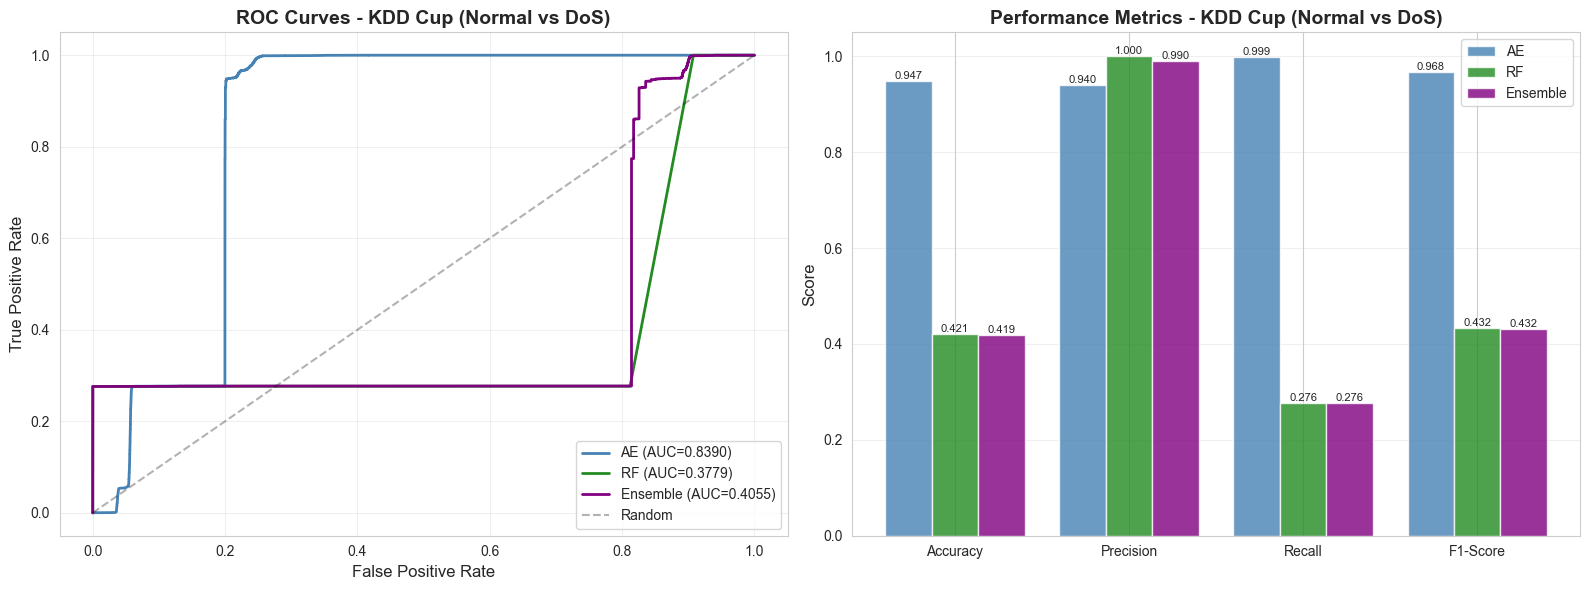

In [8]:
kdd_comparison = {
    'AE': {
        'y_true': y_test_kdd,
        'y_pred': y_pred_ae_kdd,
        'y_proba': ae_errors_kdd,
        'metrics': ae_kdd_metrics
    },
    'RF': {
        'y_true': y_test_kdd,
        'y_pred': y_pred_rf_kdd,
        'y_proba': y_proba_rf_kdd,
        'metrics': rf_kdd_metrics
    },
    'Ensemble': {
        'y_true': y_test_kdd,
        'y_pred': y_pred_ens_kdd,
        'y_proba': y_proba_ens_kdd,
        'metrics': ens_kdd_metrics
    }
}

plot_comparison(kdd_comparison, "KDD Cup (Normal vs DoS)")

---
# Part 2: CORES-IoT Dataset

## 2.1 Load CORES-IoT Data

In [9]:
CORES_IOT_PATH = '/Users/adamgruda/Projects/studies/detection-of-network-intrusions/detection-of-network-intrusions/data/cores_iot.csv'
AE_MODEL_PATH = '/Users/adamgruda/Projects/studies/detection-of-network-intrusions/detection-of-network-intrusions/models/v1_model_20251207_080312.pt'

print("Loading CORES-IoT dataset...")
X_train_cores, X_val_cores, X_test_cores, y_val_cores, y_test_cores, mean_cores, std_cores = load_cores_iot(
    path=CORES_IOT_PATH,
    normal_value=0.0,
    train_size=0.6,
    val_size=0.2
)

# Combine train and val for our split
X_all_cores = np.vstack([X_train_cores, X_val_cores, X_test_cores])
y_all_cores = np.concatenate([
    np.zeros(len(X_train_cores)),
    y_val_cores,
    y_test_cores
])

# Re-split consistently
X_train_cores, X_temp, y_train_cores, y_temp = train_test_split(
    X_all_cores, y_all_cores, test_size=0.4, random_state=42, stratify=y_all_cores
)
X_val_cores, X_test_cores, y_val_cores, y_test_cores = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\nData splits:")
print(f"  Train: {X_train_cores.shape[0]:,} samples ({(y_train_cores==0).sum():,} normal, {(y_train_cores==1).sum():,} attack)")
print(f"  Val:   {X_val_cores.shape[0]:,} samples ({(y_val_cores==0).sum():,} normal, {(y_val_cores==1).sum():,} attack)")
print(f"  Test:  {X_test_cores.shape[0]:,} samples ({(y_test_cores==0).sum():,} normal, {(y_test_cores==1).sum():,} attack)")
print(f"\nFeatures: {X_train_cores.shape[1]}")

Loading CORES-IoT dataset...

Data splits:
  Train: 774,187 samples (450,504 normal, 323,683 attack)
  Val:   258,063 samples (150,168 normal, 107,895 attack)
  Test:  258,063 samples (150,168 normal, 107,895 attack)

Features: 19


## 2.2 Load Pre-trained Autoencoder

In [10]:
print(f"Loading pre-trained autoencoder from {Path(AE_MODEL_PATH).name}...")
ae_cores = Autoencoder.load_model_with_weights(
    input_dim=19,
    latent_dim=32,
    weights_path=AE_MODEL_PATH,
    device=device
)
ae_cores.eval()

print(f"✓ Model loaded on {device}")
print(f"\nArchitecture: 19 features → 32 latent → 19 features")

Loading pre-trained autoencoder from v1_model_20251207_080312.pt...
✓ Model loaded on cpu

Architecture: 19 features → 32 latent → 19 features


/Users/adamgruda/Projects/studies/detection-of-network-intrusions/detection-of-network-intrusions/src/autoencoder/autoencoder.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featu

## 2.3 Train Random Forest on CORES-IoT

In [11]:
print("Training Random Forest on CORES-IoT...")
rf_cores = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_cores.fit(X_train_cores, y_train_cores)
print("✓ RF trained")

Training Random Forest on CORES-IoT...
✓ RF trained


## 2.4 Evaluate Models on CORES-IoT

In [12]:
from sklearn.metrics import precision_recall_curve

print("="*70)
print("CORES-IoT - MODEL EVALUATION")
print("="*70)

# Random Forest baseline
y_pred_rf_cores = rf_cores.predict(X_test_cores)
y_proba_rf_cores = rf_cores.predict_proba(X_test_cores)
rf_cores_metrics = evaluate_model(y_test_cores, y_pred_rf_cores, y_proba_rf_cores, "Random Forest")
print_confusion_matrix(y_test_cores, y_pred_rf_cores, "Random Forest")

# Autoencoder baseline (using reconstruction errors)
with torch.no_grad():
    X_tensor = torch.from_numpy(X_test_cores).float().to(device)
    recon = ae_cores(X_tensor)
    ae_errors = torch.mean((recon - X_tensor) ** 2, dim=1).cpu().numpy()

# Find optimal threshold using precision-recall curve (correct method from evaluate.py)
precision, recall, pr_thresholds = precision_recall_curve(y_test_cores, ae_errors)
f1_scores = np.where(
    (precision + recall) == 0,
    0,
    2 * (precision * recall) / (precision + recall)
)
optimal_index = np.argmax(f1_scores)
if optimal_index < len(pr_thresholds):
    ae_threshold = pr_thresholds[optimal_index]
else:
    ae_threshold = pr_thresholds[-1] if len(pr_thresholds) > 0 else 0.0

print(f"\nAutoencoder optimal threshold: {ae_threshold:.6f}")

y_pred_ae_cores = (ae_errors >= ae_threshold).astype(int)
ae_cores_metrics = evaluate_model(y_test_cores, y_pred_ae_cores, ae_errors, "Autoencoder")
print_confusion_matrix(y_test_cores, y_pred_ae_cores, "Autoencoder")

# Create ensemble
ensemble_cores = HybridIntrusionEnsemble(
    rf_model=rf_cores,
    ae_model=ae_cores,
    rf_weight=0.5,
    ae_weight=0.5,
    threshold=0.4,
    device=device
)

# Calibrate on normal validation samples
X_normal_val_cores = X_val_cores[y_val_cores == 0]
ensemble_cores.fit(X_normal_val_cores)
print(f"\n✓ Ensemble calibrated on {len(X_normal_val_cores):,} normal samples")
print(f"  AE error range: [{ensemble_cores.ae_min_error_:.6f}, {ensemble_cores.ae_max_error_:.6f}]")

# Evaluate ensemble
y_pred_ens_cores = ensemble_cores.predict(X_test_cores)
y_proba_ens_cores = ensemble_cores.predict_proba(X_test_cores)
ens_cores_metrics = evaluate_model(y_test_cores, y_pred_ens_cores, y_proba_ens_cores, "Hybrid Ensemble")
print_confusion_matrix(y_test_cores, y_pred_ens_cores, "Hybrid Ensemble")

CORES-IoT - MODEL EVALUATION

📊 Random Forest:
  accuracy    : 0.9987
  precision   : 0.9970
  recall      : 0.9999
  f1_score    : 0.9985
  roc_auc     : 1.0000

Random Forest - Confusion Matrix:
  TN=149844  FP=   324
  FN=     7  TP=107888


/var/folders/h0/00jxjppn1yd6zq_bs8qqb9tw0000gn/T/ipykernel_38644/823651462.py:24: RuntimeWarning: invalid value encountered in divide
  2 * (precision * recall) / (precision + recall)
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Autoencoder optimal threshold: 0.001557

📊 Autoencoder:
  accuracy    : 0.8941
  precision   : 0.8038
  recall      : 0.9878
  f1_score    : 0.8864
  roc_auc     : 0.9087

Autoencoder - Confusion Matrix:
  TN=124151  FP= 26017
  FN=  1314  TP=106581

✓ Ensemble calibrated on 150,168 normal samples
  AE error range: [0.000092, 0.029141]


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



📊 Hybrid Ensemble:
  accuracy    : 0.9910
  precision   : 0.9790
  recall      : 0.9999
  f1_score    : 0.9893
  roc_auc     : 0.9990

Hybrid Ensemble - Confusion Matrix:
  TN=147851  FP=  2317
  FN=     8  TP=107887


## 2.5 Visualize CORES-IoT Results

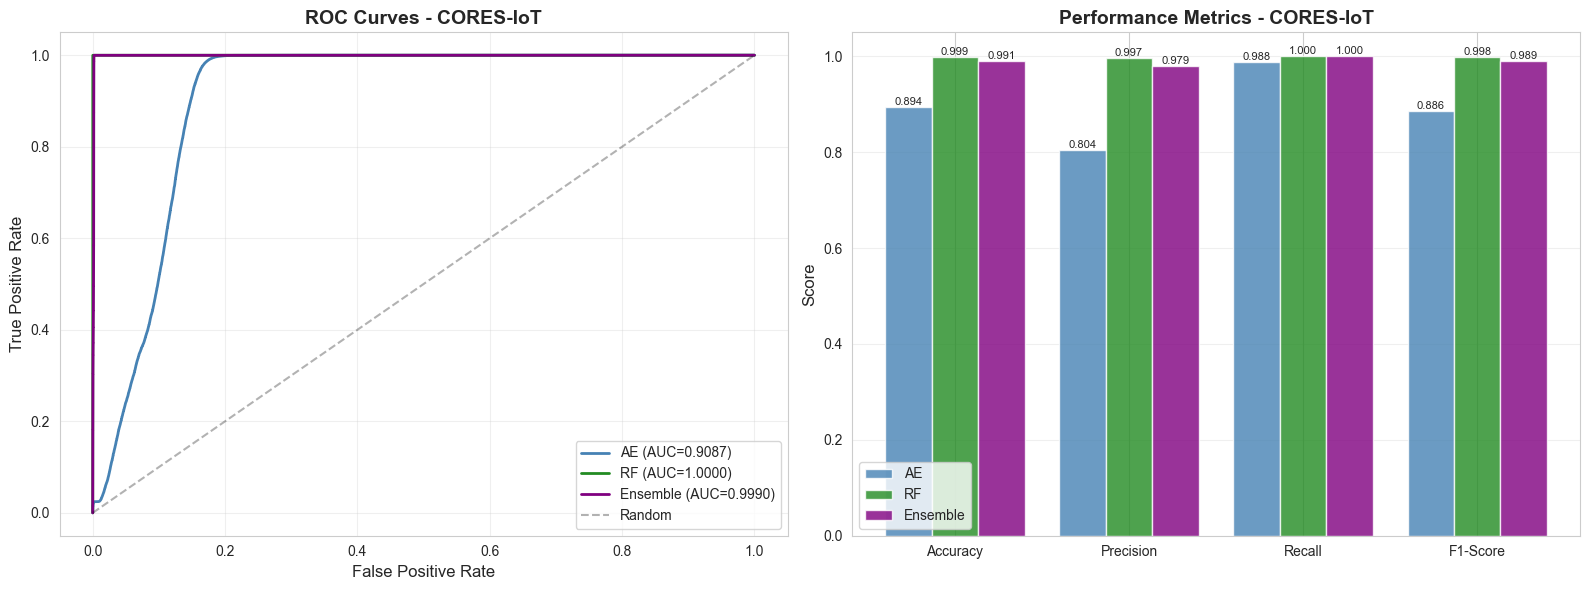

In [13]:
cores_comparison = {
    'AE': {
        'y_true': y_test_cores,
        'y_pred': y_pred_ae_cores,
        'y_proba': ae_errors,
        'metrics': ae_cores_metrics
    },
    'RF': {
        'y_true': y_test_cores,
        'y_pred': y_pred_rf_cores,
        'y_proba': y_proba_rf_cores,
        'metrics': rf_cores_metrics
    },
    'Ensemble': {
        'y_true': y_test_cores,
        'y_pred': y_pred_ens_cores,
        'y_proba': y_proba_ens_cores,
        'metrics': ens_cores_metrics
    }
}

plot_comparison(cores_comparison, "CORES-IoT")

---
# Part 3: Weight Optimization

## 3.1 Grid Search on KDD

In [14]:
from src.ensemble import grid_search_weights

print("Running grid search on KDD...")
search_results_kdd = grid_search_weights(
    rf_model=rf_kdd,
    ae_model=ae_kdd,
    X_train=X_normal_val_kdd,  # Calibrate on normal samples
    y_train=None,
    X_val=X_test_kdd_scaled,
    y_val=y_test_kdd,
    rf_weights=[0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    thresholds=[0.3, 0.4, 0.5],
    metric='f1',
    verbose=True
)

# Show top configurations
df_results_kdd = pd.DataFrame(search_results_kdd['all_results']).sort_values('f1_score', ascending=False)
print("\n📊 TOP 5 CONFIGURATIONS:")
print(df_results_kdd[['rf_weight', 'threshold', 'accuracy', 'f1_score', 'roc_auc']].head())

Running grid search on KDD...


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[1/18] rf_weight=0.5, threshold=0.3 → f1=0.4316


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[2/18] rf_weight=0.5, threshold=0.4 → f1=0.0017


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[3/18] rf_weight=0.5, threshold=0.5 → f1=0.0009


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[4/18] rf_weight=0.6, threshold=0.3 → f1=0.4318


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[5/18] rf_weight=0.6, threshold=0.4 → f1=0.4318


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[6/18] rf_weight=0.6, threshold=0.5 → f1=0.0009


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[7/18] rf_weight=0.7, threshold=0.3 → f1=0.4319


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[8/18] rf_weight=0.7, threshold=0.4 → f1=0.4328


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[9/18] rf_weight=0.7, threshold=0.5 → f1=0.0021


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[10/18] rf_weight=0.8, threshold=0.3 → f1=0.4328


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[11/18] rf_weight=0.8, threshold=0.4 → f1=0.4328


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[12/18] rf_weight=0.8, threshold=0.5 → f1=0.3991


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[13/18] rf_weight=0.9, threshold=0.3 → f1=0.4328


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[14/18] rf_weight=0.9, threshold=0.4 → f1=0.4328


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[15/18] rf_weight=0.9, threshold=0.5 → f1=0.4328


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[16/18] rf_weight=1.0, threshold=0.3 → f1=0.4328


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[17/18] rf_weight=1.0, threshold=0.4 → f1=0.4328


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[18/18] rf_weight=1.0, threshold=0.5 → f1=0.4325

✓ Best configuration: {'rf_weight': 1.0, 'ae_weight': 0.0, 'threshold': 0.4, 'score': 0.4328498847875127}

📊 TOP 5 CONFIGURATIONS:
    rf_weight  threshold  accuracy  f1_score   roc_auc
16        1.0        0.4  0.421181  0.432850  0.377920
13        0.9        0.4  0.421181  0.432849  0.379325
10        0.8        0.4  0.421166  0.432833  0.370840
12        0.9        0.3  0.421098  0.432817  0.379325
14        0.9        0.5  0.421169  0.432816  0.379325


## 3.2 Visualize KDD Grid Search

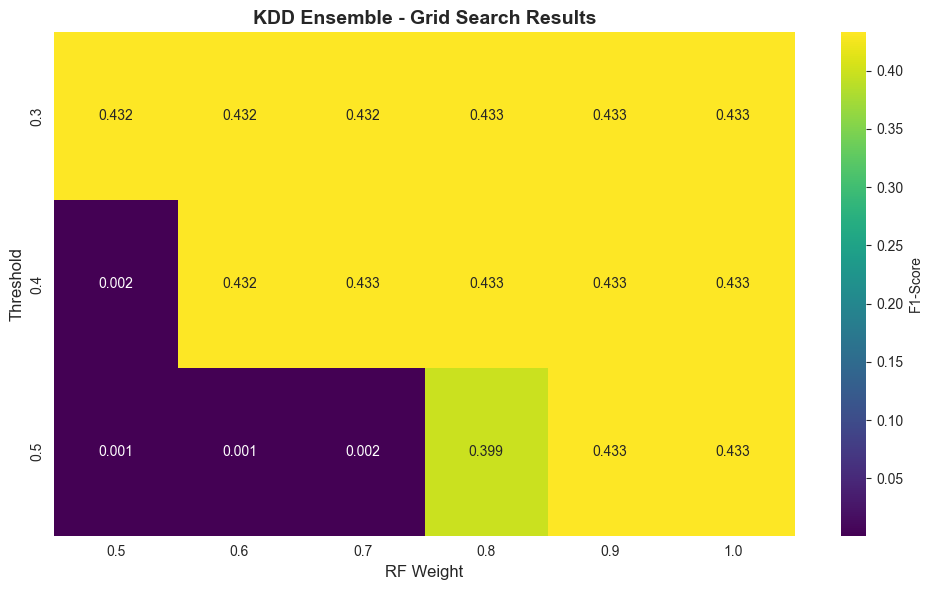

In [15]:
# Heatmap of grid search results
fig, ax = plt.subplots(figsize=(10, 6))

pivot = df_results_kdd.pivot(index='threshold', columns='rf_weight', values='f1_score')
sns.heatmap(pivot, annot=True, fmt='.3f', cmap='viridis', ax=ax, cbar_kws={'label': 'F1-Score'})
ax.set_title('KDD Ensemble - Grid Search Results', fontsize=14, fontweight='bold')
ax.set_xlabel('RF Weight', fontsize=12)
ax.set_ylabel('Threshold', fontsize=12)

plt.tight_layout()
plt.show()

## 3.3 Grid Search on Cores-IoT

In [16]:
print("Running grid search on CORES-IoT...")
search_results_cores = grid_search_weights(
    rf_model=rf_cores,
    ae_model=ae_cores,
    X_train=X_normal_val_cores,  # Calibrate on normal samples
    y_train=None,
    X_val=X_test_cores,
    y_val=y_test_cores,
    rf_weights=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    thresholds=[0.3, 0.4, 0.5, 0.6],
    metric='f1',
    verbose=True
)

# Show top configurations
df_results_cores = pd.DataFrame(search_results_cores['all_results']).sort_values('f1_score', ascending=False)
print("\n📊 TOP 5 CONFIGURATIONS:")
print(df_results_cores[['rf_weight', 'threshold', 'accuracy', 'f1_score', 'roc_auc']].head())

Running grid search on CORES-IoT...


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[1/44] rf_weight=0.0, threshold=0.3 → f1=0.3822


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[2/44] rf_weight=0.0, threshold=0.4 → f1=0.2745


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[3/44] rf_weight=0.0, threshold=0.5 → f1=0.1810


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[4/44] rf_weight=0.0, threshold=0.6 → f1=0.1171


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[5/44] rf_weight=0.1, threshold=0.3 → f1=0.4686


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[6/44] rf_weight=0.1, threshold=0.4 → f1=0.3501


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[7/44] rf_weight=0.1, threshold=0.5 → f1=0.2312


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[8/44] rf_weight=0.1, threshold=0.6 → f1=0.1411


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[9/44] rf_weight=0.2, threshold=0.3 → f1=0.5688


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[10/44] rf_weight=0.2, threshold=0.4 → f1=0.4465


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[11/44] rf_weight=0.2, threshold=0.5 → f1=0.3070


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[12/44] rf_weight=0.2, threshold=0.6 → f1=0.1815


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[13/44] rf_weight=0.3, threshold=0.3 → f1=0.9747


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[14/44] rf_weight=0.3, threshold=0.4 → f1=0.5410


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[15/44] rf_weight=0.3, threshold=0.5 → f1=0.4106


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[16/44] rf_weight=0.3, threshold=0.6 → f1=0.2467


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[17/44] rf_weight=0.4, threshold=0.3 → f1=0.9781


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[18/44] rf_weight=0.4, threshold=0.4 → f1=0.9864


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[19/44] rf_weight=0.4, threshold=0.5 → f1=0.5224


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[20/44] rf_weight=0.4, threshold=0.6 → f1=0.3531


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[21/44] rf_weight=0.5, threshold=0.3 → f1=0.9818


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[22/44] rf_weight=0.5, threshold=0.4 → f1=0.9893


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[23/44] rf_weight=0.5, threshold=0.5 → f1=0.9923


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[24/44] rf_weight=0.5, threshold=0.6 → f1=0.5047


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[25/44] rf_weight=0.6, threshold=0.3 → f1=0.9862


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[26/44] rf_weight=0.6, threshold=0.4 → f1=0.9916


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[27/44] rf_weight=0.6, threshold=0.5 → f1=0.9993


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[28/44] rf_weight=0.6, threshold=0.6 → f1=0.9991


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[29/44] rf_weight=0.7, threshold=0.3 → f1=0.9901


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[30/44] rf_weight=0.7, threshold=0.4 → f1=0.9983


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[31/44] rf_weight=0.7, threshold=0.5 → f1=0.9993


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[32/44] rf_weight=0.7, threshold=0.6 → f1=0.9996


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[33/44] rf_weight=0.8, threshold=0.3 → f1=0.9979


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[34/44] rf_weight=0.8, threshold=0.4 → f1=0.9983


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[35/44] rf_weight=0.8, threshold=0.5 → f1=0.9991


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[36/44] rf_weight=0.8, threshold=0.6 → f1=0.9995


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[37/44] rf_weight=0.9, threshold=0.3 → f1=0.9982


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[38/44] rf_weight=0.9, threshold=0.4 → f1=0.9984


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[39/44] rf_weight=0.9, threshold=0.5 → f1=0.9987


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[40/44] rf_weight=0.9, threshold=0.6 → f1=0.9994


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[41/44] rf_weight=1.0, threshold=0.3 → f1=0.9982


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[42/44] rf_weight=1.0, threshold=0.4 → f1=0.9984


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[43/44] rf_weight=1.0, threshold=0.5 → f1=0.9985


/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adamgruda/miniconda3/envs/dashboard/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[44/44] rf_weight=1.0, threshold=0.6 → f1=0.9992

✓ Best configuration: {'rf_weight': 0.7, 'ae_weight': 0.30000000000000004, 'threshold': 0.6, 'score': 0.9996247376638298}

📊 TOP 5 CONFIGURATIONS:
    rf_weight  threshold  accuracy  f1_score   roc_auc
31        0.7        0.6  0.999686  0.999625  0.999935
35        0.8        0.6  0.999593  0.999514  0.999976
39        0.9        0.6  0.999465  0.999361  0.999995
30        0.7        0.5  0.999419  0.999305  0.999935
26        0.6        0.5  0.999411  0.999296  0.999796


## 3.4 Visualize Grid Search Cores-IoT

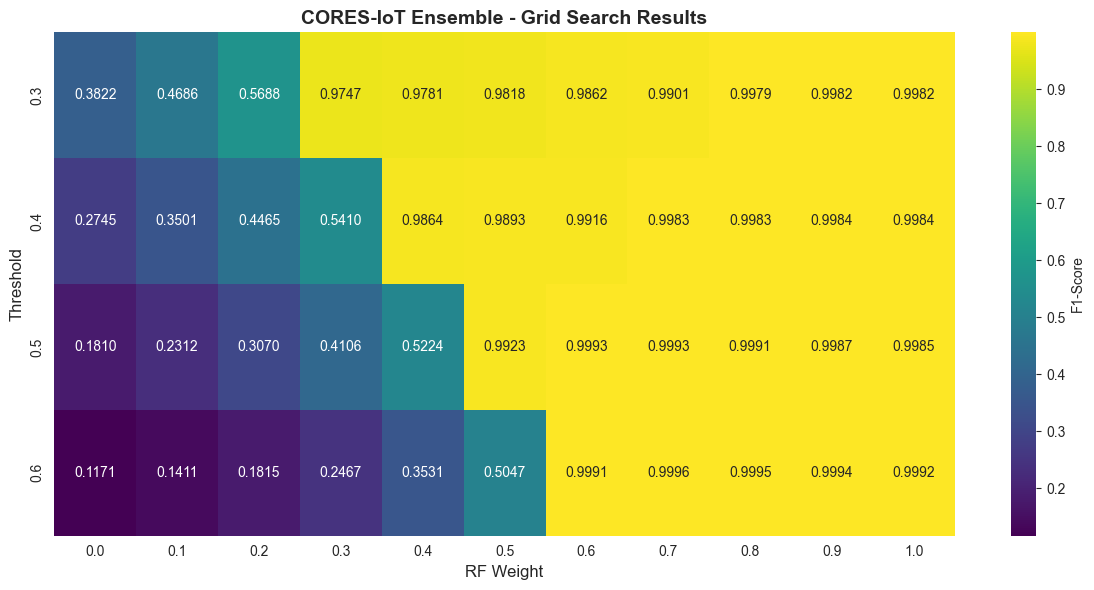

In [17]:


# Heatmap of grid search results for CORES-IoT
fig, ax = plt.subplots(figsize=(12, 6))

pivot = df_results_cores.pivot(index='threshold', columns='rf_weight', values='f1_score')
sns.heatmap(pivot, annot=True, fmt='.4f', cmap='viridis', ax=ax, cbar_kws={'label': 'F1-Score'})
ax.set_title('CORES-IoT Ensemble - Grid Search Results', fontsize=14, fontweight='bold')
ax.set_xlabel('RF Weight', fontsize=12)
ax.set_ylabel('Threshold', fontsize=12)

plt.tight_layout()
plt.show()

---
# Summary

In [19]:
import json
from datetime import datetime

print("="*70)
print("FINAL SUMMARY")
print("="*70)

print("\n📊 KDD Cup (Normal vs DoS):")
print(f"  AE Baseline:     F1={ae_kdd_metrics['f1_score']:.4f}, AUC={ae_kdd_metrics['roc_auc']:.4f}")
print(f"  RF Baseline:     F1={rf_kdd_metrics['f1_score']:.4f}, AUC={rf_kdd_metrics['roc_auc']:.4f}")
print(f"  Ensemble:        F1={ens_kdd_metrics['f1_score']:.4f}, AUC={ens_kdd_metrics['roc_auc']:.4f}")
print(f"  Improvement:     ΔF1={ens_kdd_metrics['f1_score'] - max(rf_kdd_metrics['f1_score'], ae_kdd_metrics['f1_score']):+.4f}")

print("\n📊 CORES-IoT:")
print(f"  AE Baseline:     F1={ae_cores_metrics['f1_score']:.4f}, AUC={ae_cores_metrics['roc_auc']:.4f}")
print(f"  RF Baseline:     F1={rf_cores_metrics['f1_score']:.4f}, AUC={rf_cores_metrics['roc_auc']:.4f}")
print(f"  Ensemble:        F1={ens_cores_metrics['f1_score']:.4f}, AUC={ens_cores_metrics['roc_auc']:.4f}")
print(f"  Improvement:     ΔF1={ens_cores_metrics['f1_score'] - max(rf_cores_metrics['f1_score'], ae_cores_metrics['f1_score']):+.4f}")

print("\n" + "="*70)

# Save comprehensive results
results_dict = {
    'timestamp': datetime.now().strftime('%Y%m%d_%H%M%S'),
    'kdd_cup': {
        'autoencoder': ae_kdd_metrics,
        'random_forest': rf_kdd_metrics,
        'ensemble': ens_kdd_metrics,
        'improvement_f1': float(ens_kdd_metrics['f1_score'] - max(rf_kdd_metrics['f1_score'], ae_kdd_metrics['f1_score'])),
        'grid_search_best': search_results_kdd['best_config'],
        'grid_search_top5': df_results_kdd[['rf_weight', 'threshold', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']].head().to_dict('records')
    },
    'cores_iot': {
        'autoencoder': ae_cores_metrics,
        'random_forest': rf_cores_metrics,
        'ensemble': ens_cores_metrics,
        'improvement_f1': float(ens_cores_metrics['f1_score'] - max(rf_cores_metrics['f1_score'], ae_cores_metrics['f1_score'])),
        'grid_search_best': search_results_cores['best_config'],
        'grid_search_top5': df_results_cores[['rf_weight', 'threshold', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']].head().to_dict('records')
    }
}

# Save to results directory
results_dir = Path.cwd() / 'results'
results_dir.mkdir(exist_ok=True)

results_file = results_dir / f"ensemble_evaluation_{results_dict['timestamp']}.json"
with open(results_file, 'w') as f:
    json.dump(results_dict, f, indent=2)

print(f"\n✓ Results saved to: {results_file.name}")
print(f"  Location: {results_dir}")

# Save figures
print("\n📊 Saving figures...")
timestamp = results_dict['timestamp']

# 1. KDD Model Comparison (ROC + Metrics)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
colors = ['steelblue', 'forestgreen', 'purple']
model_names = ['AE', 'RF', 'Ensemble']
model_data = [
    (ae_kdd_metrics, y_pred_ae_kdd, ae_errors_kdd),
    (rf_kdd_metrics, y_pred_rf_kdd, y_proba_rf_kdd),
    (ens_kdd_metrics, y_pred_ens_kdd, y_proba_ens_kdd)
]

# ROC Curves
ax = axes[0]
for (name, (metrics, y_pred, y_proba)), color in zip(zip(model_names, model_data), colors):
    proba = y_proba[:, 1] if y_proba.ndim > 1 else y_proba
    fpr, tpr, _ = roc_curve(y_test_kdd, proba)
    ax.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC={metrics["roc_auc"]:.4f})', color=color)
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - KDD Cup (Normal vs DoS)', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

# Metrics
ax = axes[1]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metric_keys = ['accuracy', 'precision', 'recall', 'f1_score']
x = np.arange(len(metric_names))
width = 0.25
for i, (name, (metrics, _, _), color) in enumerate(zip(model_names, model_data, colors)):
    values = [metrics[k] for k in metric_keys]
    bars = ax.bar(x + i*width - width, values, width, label=name, color=color, alpha=0.8)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', 
                ha='center', va='bottom', fontsize=8)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Performance Metrics - KDD Cup', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.legend()
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(results_dir / f'kdd_model_comparison_{timestamp}.png', dpi=300, bbox_inches='tight')
plt.close()

# 2. CORES-IoT Model Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
model_data_cores = [
    (ae_cores_metrics, y_pred_ae_cores, ae_errors),
    (rf_cores_metrics, y_pred_rf_cores, y_proba_rf_cores),
    (ens_cores_metrics, y_pred_ens_cores, y_proba_ens_cores)
]

# ROC Curves
ax = axes[0]
for (name, (metrics, y_pred, y_proba)), color in zip(zip(model_names, model_data_cores), colors):
    proba = y_proba[:, 1] if y_proba.ndim > 1 else y_proba
    fpr, tpr, _ = roc_curve(y_test_cores, proba)
    ax.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC={metrics["roc_auc"]:.4f})', color=color)
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - CORES-IoT', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

# Metrics
ax = axes[1]
for i, (name, (metrics, _, _), color) in enumerate(zip(model_names, model_data_cores, colors)):
    values = [metrics[k] for k in metric_keys]
    bars = ax.bar(x + i*width - width, values, width, label=name, color=color, alpha=0.8)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', 
                ha='center', va='bottom', fontsize=8)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Performance Metrics - CORES-IoT', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.legend()
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(results_dir / f'cores_model_comparison_{timestamp}.png', dpi=300, bbox_inches='tight')
plt.close()

# 3. KDD Grid Search Heatmap
fig, ax = plt.subplots(figsize=(10, 6))
pivot = df_results_kdd.pivot(index='threshold', columns='rf_weight', values='f1_score')
sns.heatmap(pivot, annot=True, fmt='.3f', cmap='viridis', ax=ax, cbar_kws={'label': 'F1-Score'})
ax.set_title('KDD Ensemble - Grid Search Results', fontsize=14, fontweight='bold')
ax.set_xlabel('RF Weight', fontsize=12)
ax.set_ylabel('Threshold', fontsize=12)
plt.tight_layout()
plt.savefig(results_dir / f'kdd_grid_search_{timestamp}.png', dpi=300, bbox_inches='tight')
plt.close()

# 4. CORES-IoT Grid Search Heatmap
fig, ax = plt.subplots(figsize=(12, 6))
pivot = df_results_cores.pivot(index='threshold', columns='rf_weight', values='f1_score')
sns.heatmap(pivot, annot=True, fmt='.4f', cmap='viridis', ax=ax, cbar_kws={'label': 'F1-Score'})
ax.set_title('CORES-IoT Ensemble - Grid Search Results', fontsize=14, fontweight='bold')
ax.set_xlabel('RF Weight', fontsize=12)
ax.set_ylabel('Threshold', fontsize=12)
plt.tight_layout()
plt.savefig(results_dir / f'cores_grid_search_{timestamp}.png', dpi=300, bbox_inches='tight')
plt.close()

print(f"  ✓ kdd_model_comparison_{timestamp}.png")
print(f"  ✓ cores_model_comparison_{timestamp}.png")
print(f"  ✓ kdd_grid_search_{timestamp}.png")
print(f"  ✓ cores_grid_search_{timestamp}.png")
print(f"\nAll results saved to: {results_dir}")

FINAL SUMMARY

📊 KDD Cup (Normal vs DoS):
  AE Baseline:     F1=0.9682, AUC=0.8390
  RF Baseline:     F1=0.4325, AUC=0.3779
  Ensemble:        F1=0.4319, AUC=0.4055
  Improvement:     ΔF1=-0.5362

📊 CORES-IoT:
  AE Baseline:     F1=0.8864, AUC=0.9087
  RF Baseline:     F1=0.9985, AUC=1.0000
  Ensemble:        F1=0.9893, AUC=0.9990
  Improvement:     ΔF1=-0.0091


✓ Results saved to: ensemble_evaluation_20260111_141228.json
  Location: /Users/adamgruda/Projects/studies/detection-of-network-intrusions/detection-of-network-intrusions/src/ensemble/results

📊 Saving figures...
  ✓ kdd_model_comparison_20260111_141228.png
  ✓ cores_model_comparison_20260111_141228.png
  ✓ kdd_grid_search_20260111_141228.png
  ✓ cores_grid_search_20260111_141228.png

All results saved to: /Users/adamgruda/Projects/studies/detection-of-network-intrusions/detection-of-network-intrusions/src/ensemble/results
